In [1]:
import torch
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import numpy as np
from datasets import load_dataset
from transformers import AutoProcessor, AutoModelForCausalLM

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# Load pre-trained GIT model and processor
processor = AutoProcessor.from_pretrained("microsoft/git-base")
model = AutoModelForCausalLM.from_pretrained("microsoft/git-base")
model = model.to(device)

# Creating a Dataset class 
class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        encoding = self.processor(
            images=item["image"], 
            text=item["text"], 
            padding="max_length", 
            return_tensors="pt"
        )
        encoding = {k: v.squeeze() for k, v in encoding.items()}
        return encoding

preprocessor_config.json:   0%|          | 0.00/503 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/453 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/2.82k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/707M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

In [3]:
# Loading the FACAD fashion dataset from HuggingFace
ds = load_dataset("Luna288/image-captioning-FACAD-base")

# Randomly selecting 5000 images from the large dataset for efficient computation
sampled_ds = ds['train'].shuffle(seed=42).select(range(5000))
shuffled_ds = sampled_ds.shuffle(seed=42)

# Creating a train and test datasets for future use
train_ds = shuffled_ds.select(range(4000))
test_ds = shuffled_ds.select(range(4000, 5000))

# Creating the dataset and dataloader instances
train_dataset = ImageCaptioningDataset(train_ds, processor)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=8)

README.md:   0%|          | 0.00/392 [00:00<?, ?B/s]

train-00000-of-00002.parquet:   0%|          | 0.00/365M [00:00<?, ?B/s]

train-00001-of-00002.parquet:   0%|          | 0.00/364M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/123653 [00:00<?, ? examples/s]

In [4]:
# Optimizer for fine-tuning 
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

# Training loop
model.train()
for epoch in range(2):
    print(f"Epoch: {epoch}")
    for idx, batch in enumerate(train_dataloader):
        input_ids = batch.pop("input_ids").to(device)
        pixel_values = batch.pop("pixel_values").to(device)

        outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=input_ids)
        loss = outputs.loss

        print(f"Loss at step {idx}: {loss.item()}")

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# Saving the fine-tuned model
model.save_pretrained("path_to_save_finetuned_model")
processor.save_pretrained("path_to_save_finetuned_model")

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Epoch: 0
Loss at step 0: 11.897680282592773
Loss at step 1: 10.402713775634766
Loss at step 2: 9.957779884338379
Loss at step 3: 9.697242736816406
Loss at step 4: 9.466227531433105
Loss at step 5: 9.233213424682617
Loss at step 6: 9.046422004699707
Loss at step 7: 8.900032043457031
Loss at step 8: 8.72327995300293
Loss at step 9: 8.58852481842041
Loss at step 10: 8.467214584350586
Loss at step 11: 8.37211799621582
Loss at step 12: 8.228742599487305
Loss at step 13: 8.139540672302246
Loss at step 14: 8.040953636169434
Loss at step 15: 7.918177127838135
Loss at step 16: 7.857264518737793
Loss at step 17: 7.715683937072754
Loss at step 18: 7.634641647338867
Loss at step 19: 7.532634735107422
Loss at step 20: 7.420973777770996
Loss at step 21: 7.307352542877197
Loss at step 22: 7.21478271484375
Loss at step 23: 7.13847017288208
Loss at step 24: 7.039770603179932
Loss at step 25: 6.930861473083496
Loss at step 26: 6.830677509307861
Loss at step 27: 6.698602676391602
Loss at step 28: 6.62913

[]

In [5]:
# Logging into HuggingFace
from huggingface_hub import login

login()

In [6]:
# Creating a HuggingFace repository for my model
from huggingface_hub import create_repo

repo_id = "sagniksengupta/git-finetuned-facad"
create_repo(repo_id)

RepoUrl('https://huggingface.co/sagniksengupta/git-finetuned-facad', endpoint='https://huggingface.co', repo_type='model', repo_id='sagniksengupta/git-finetuned-facad')

In [7]:
# Loading my locally saved model and processor
model = AutoModelForCausalLM.from_pretrained("path_to_save_finetuned_model")
processor = AutoProcessor.from_pretrained("path_to_save_finetuned_model")

# Pushing the model to the HuggingFace Hub
model.push_to_hub(repo_id)
processor.push_to_hub(repo_id)

model.safetensors:   0%|          | 0.00/707M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/sagniksengupta/git-finetuned-facad/commit/1e9de5ce1b8ea557f8da37e3cce7369af2ec2428', commit_message='Upload processor', commit_description='', oid='1e9de5ce1b8ea557f8da37e3cce7369af2ec2428', pr_url=None, repo_url=RepoUrl('https://huggingface.co/sagniksengupta/git-finetuned-facad', endpoint='https://huggingface.co', repo_type='model', repo_id='sagniksengupta/git-finetuned-facad'), pr_revision=None, pr_num=None)

In [8]:
# Loading my custom model from HuggingFace for inference on an image
model = AutoModelForCausalLM.from_pretrained("sagniksengupta/git-finetuned-facad")
processor = AutoProcessor.from_pretrained("sagniksengupta/git-finetuned-facad")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

config.json:   0%|          | 0.00/869 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/707M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/136 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/503 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

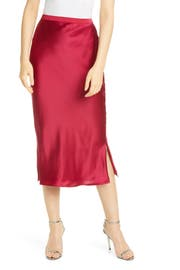

In [9]:
# Loading a test image from the testing dataset
example = test_ds[420]
image = example["image"]
image

In [10]:
# Generating the caption for the test image
inputs = processor(images=image, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values

generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
generated_caption

'a bold color blocked sheath is a versatile choice for your everyday wardrobe'

In [11]:
# Saving the train and test datasets splits for future inference
train_ds.to_parquet("path_to_save_train_dataset/train_dataset.parquet")
test_ds.to_parquet("path_to_save_test_dataset/test_dataset.parquet")

Creating parquet from Arrow format:   0%|          | 0/40 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/10 [00:00<?, ?ba/s]

6506863